<a href="https://colab.research.google.com/github/wayhall/DumpColab/blob/main/Network_Evaluation_and_Normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluation of Neural Networks

## Learning Objectives

- use `keras` to code up a neural network model;
- use wrappers inside `keras` to make models that can jibe with `sklearn`;
- scale input data via normalization to promote faster training convergence.

## Architecting a [Sequential Model](https://www.tensorflow.org/guide/keras/sequential_model)

### Setup
```
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
```

### When to Use a Sequential Model

A `Sequential` model is appropriate for **a plain stack of layers** where each layer has **exactly one input tensor and one output tensor**.

Schematically, this `Sequential` model:
```
# Define Sequential model with 3 layers
model = keras.Sequential(
    [
        layers.Dense(2, activation="relu", name="layer1"),
        layers.Dense(3, activation="relu", name="layer2"),
        layers.Dense(4, name="layer3"),
    ]
)
# Call model on a test input
x = tf.ones((3, 3))
y = model(x)

```

...is equivalent to this function:
```
# Create 3 layers
layer1 = layers.Dense(2, activation="relu", name="layer1")
layer2 = layers.Dense(3, activation="relu", name="layer2")
layer3 = layers.Dense(4, name="layer3")

# Call layers on a test input
x = tf.ones((3, 3))
y = layer3(layer2(layer1(x)))
```

A Sequential model is **not** appropriate when:

- Your model has multiple inputs or multiple outputs
- Any of your layers has multiple inputs or multiple outputs
- You need to do layer sharing
- You want non-linear topology (e.g. a residual connection, a multi-branch model)

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential()
model.add(layers.Dense(2, activation="relu"))
model.add(layers.Dense(3, activation="relu"))
model.add(layers.Dense(4))

In [2]:
model.layers

Generally, all layers in Keras need to know the shape of their inputs in order to be able to create their weights. So when you create a layer like this, initially, it has no weights:

In [3]:
# This will throw an error

model.weights

ValueError: ignored

In [4]:
# This will throw an error:

model.summary()

ValueError: ignored

**Note**: *The model creates its weights the first time it is called on an input, since the shape of the weights depends on the shape of the inputs.*

In [5]:
x = tf.ones((1, 4))
y = model(x)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (1, 2)                    10        
                                                                 
 dense_1 (Dense)             (1, 3)                    9         
                                                                 
 dense_2 (Dense)             (1, 4)                    16        
                                                                 
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________


In [6]:
x

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[1., 1., 1., 1.]], dtype=float32)>

In [7]:
model.weights

[<tf.Variable 'dense/kernel:0' shape=(4, 2) dtype=float32, numpy=
 array([[-0.7387681 ,  0.3539226 ],
        [-0.6585326 ,  0.38407183],
        [ 0.6130214 ,  0.5952382 ],
        [ 0.8695564 , -0.08927631]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>,
 <tf.Variable 'dense_1/kernel:0' shape=(2, 3) dtype=float32, numpy=
 array([[ 0.02570736,  0.9504328 ,  0.70419383],
        [-0.57236207,  0.40141547,  0.79902124]], dtype=float32)>,
 <tf.Variable 'dense_1/bias:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>,
 <tf.Variable 'dense_2/kernel:0' shape=(3, 4) dtype=float32, numpy=
 array([[ 0.92404914, -0.29289114,  0.7568848 , -0.00942022],
        [ 0.47062004,  0.8501667 , -0.05513793, -0.82372063],
        [-0.09078562,  0.43390095, -0.72143507, -0.7933419 ]],
       dtype=float32)>,
 <tf.Variable 'dense_2/bias:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>]

It can be helpful to note that there's also a corresponding `pop()` method to remove layers; a `Sequential` model behaves very much like a list of layers:

In [8]:
model.pop()
model.layers

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (1, 2)                    10        
                                                                 
 dense_1 (Dense)             (1, 3)                    9         
                                                                 
Total params: 19
Trainable params: 19
Non-trainable params: 0
_________________________________________________________________


Additionally, you'll likely recall that a `Sequential` model can also be created incrementally via the `add()` method:

In [10]:
model.add(layers.Dense(4))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (1, 2)                    10        
                                                                 
 dense_1 (Dense)             (1, 3)                    9         
                                                                 
 dense_3 (Dense)             (1, 4)                    16        
                                                                 
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________


## Back to Our Example: A Digit Classifier

In [11]:
from sklearn.datasets import load_sample_images
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
%load_ext autoreload
%autoreload 2

### Load the Digits Dataset (Again)

In [12]:
# Load and return the digits dataset (classification).
# Each datapoint is a 8x8 image of a digit.

digits = load_digits()

# Defining feature variables
X = digits.data

# Defining target variable
y = digits.target

# To tag each value as even or odd (0 is even, 1 is odd)
y_binary = y % 2

In [13]:
y_binary

array([0, 1, 0, ..., 0, 1, 0])

### Defining the Input Layer of Our Model Architecture ([Source](https://www.tensorflow.org/api_docs/python/tf/keras/layers/InputLayer))

One way is to define the input layer explicitly:

In [14]:
model = Sequential([tf.keras.layers.InputLayer(input_shape=(64,))])
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X, y_binary, epochs=50, batch_size=10)

Epoch 1/50
180/180 [==============================] - 1s 2ms/step - loss: 0.8980 - accuracy: 0.5943
Epoch 2/50
180/180 [==============================] - 0s 2ms/step - loss: 0.3856 - accuracy: 0.8164
Epoch 3/50
180/180 [==============================] - 0s 2ms/step - loss: 0.2877 - accuracy: 0.8770
Epoch 4/50
180/180 [==============================] - 0s 2ms/step - loss: 0.2485 - accuracy: 0.8937
Epoch 5/50
180/180 [==============================] - 0s 2ms/step - loss: 0.2203 - accuracy: 0.9110
Epoch 6/50
180/180 [==============================] - 0s 2ms/step - loss: 0.1978 - accuracy: 0.9104
Epoch 7/50
180/180 [==============================] - 0s 2ms/step - loss: 0.1739 - accuracy: 0.9277
Epoch 8/50
180/180 [==============================] - 0s 2ms/step - loss: 0.1491 - accuracy: 0.9393
Epoch 9/50
180/180 [==============================] - 0s 2ms/step - loss: 0.1295 - accuracy: 0.9477
Epoch 10/50
180/180 [==============================] - 0s 2ms/step - loss: 0.1218 - accuracy: 0.9466

Otherwise, it is implicitly created:

In [15]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X, y_binary, epochs=50, batch_size=10)

Epoch 1/50
180/180 [==============================] - 1s 2ms/step - loss: 0.6104 - accuracy: 0.7462
Epoch 2/50
180/180 [==============================] - 0s 2ms/step - loss: 0.2230 - accuracy: 0.9154
Epoch 3/50
180/180 [==============================] - 0s 2ms/step - loss: 0.1674 - accuracy: 0.9327
Epoch 4/50
180/180 [==============================] - 0s 2ms/step - loss: 0.1435 - accuracy: 0.9466
Epoch 5/50
180/180 [==============================] - 1s 3ms/step - loss: 0.1259 - accuracy: 0.9466
Epoch 6/50
180/180 [==============================] - 1s 3ms/step - loss: 0.1166 - accuracy: 0.9549
Epoch 7/50
180/180 [==============================] - 1s 4ms/step - loss: 0.1019 - accuracy: 0.9610
Epoch 8/50
180/180 [==============================] - 1s 4ms/step - loss: 0.0961 - accuracy: 0.9622
Epoch 9/50
180/180 [==============================] - 1s 3ms/step - loss: 0.0843 - accuracy: 0.9655
Epoch 10/50
180/180 [==============================] - 0s 2ms/step - loss: 0.0794 - accuracy: 0.9727

**It is generally recommend to use the Keras Functional model via `Input`,
(which creates an `InputLayer`) without directly using `InputLayer`.**


### Things to know:

- The data and labels in `fit()` need to be numpy arrays, not `pandas` dfs.
- Scaling your data will have a large impact on your model.
   > For our traditional input features, we would use a scaler object. For images, as long as the minimum value is 0, we can simply divide through by the maximum pixel intensity.

#### Getting data ready for modeling
**Preprocessing**:

- use train_test_split to create X_train, y_train, X_test, and y_test
- Split training data into pure_train and validation sets.
- Scale the pixel intensity to a value between 0 and 1.

Scaling our input variables will help speed up our neural network.

Since our minimum intensity is 0, we can normalize the inputs by dividing each value by the max value (16).

In [16]:
X_train, X_test, y_train, y_test =\
    train_test_split(X, y_binary, random_state=42, test_size=0.2)

X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train, random_state=42, test_size=0.2)

X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

In [17]:
X_pure_train[0]

array([0.    , 0.    , 0.    , 0.25  , 0.875 , 0.875 , 0.0625, 0.    ,
       0.    , 0.    , 0.1875, 0.875 , 0.75  , 0.625 , 0.25  , 0.    ,
       0.    , 0.1875, 0.8125, 0.25  , 0.    , 0.5   , 0.375 , 0.    ,
       0.    , 0.1875, 0.9375, 0.5625, 0.125 , 0.9375, 0.0625, 0.    ,
       0.    , 0.    , 0.125 , 0.625 , 1.    , 0.8125, 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.75  , 0.875 , 0.25  , 0.    ,
       0.    , 0.    , 0.    , 0.125 , 0.75  , 0.5625, 0.1875, 0.    ,
       0.    , 0.    , 0.    , 0.125 , 1.    , 0.875 , 0.    , 0.    ])

For activation, let's start with the familiar sigmoid function, and see how it performs.

In [18]:
model = Sequential()
# We will start with our trusty sigmoid function.
# What does input dimension correspond to?
model.add(Dense(12, activation='sigmoid', input_dim=64))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD' ,
              # We use binary_crossentropy for a binary loss function
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output. To see
# only the metrics at the end of each epoch, set verbose=2.
results = model.fit(X_pure_train, y_pure_train, epochs=10, batch_size=100, verbose=1)

Epoch 1/10
12/12 [==============================] - 1s 4ms/step - loss: 0.7135 - accuracy: 0.5039
Epoch 2/10
12/12 [==============================] - 0s 3ms/step - loss: 0.7095 - accuracy: 0.5039
Epoch 3/10
12/12 [==============================] - 0s 3ms/step - loss: 0.7063 - accuracy: 0.5039
Epoch 4/10
12/12 [==============================] - 0s 3ms/step - loss: 0.7039 - accuracy: 0.5039
Epoch 5/10
12/12 [==============================] - 0s 4ms/step - loss: 0.7018 - accuracy: 0.5039
Epoch 6/10
12/12 [==============================] - 0s 3ms/step - loss: 0.7001 - accuracy: 0.5039
Epoch 7/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6988 - accuracy: 0.5039
Epoch 8/10
12/12 [==============================] - 0s 4ms/step - loss: 0.6978 - accuracy: 0.5039
Epoch 9/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6970 - accuracy: 0.5039
Epoch 10/10
12/12 [==============================] - 0s 3ms/step - loss: 0.6962 - accuracy: 0.5039


We can access the history of our model via `results.history`.
Use __dict__ to take a tour.

In [19]:
results.__dict__

{'validation_data': None,
 'model': <keras.engine.sequential.Sequential at 0x7ffa8694ba90>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [0.7135087251663208,
   0.7094948887825012,
   0.7063273191452026,
   0.7039060592651367,
   0.7017707824707031,
   0.7000734806060791,
   0.6987537145614624,
   0.6977713108062744,
   0.6969839334487915,
   0.6962451934814453],
  'accuracy': [0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566,
   0.5039164423942566]},
 'params': {'verbose': 1, 'epochs': 10, 'steps': 12},
 'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}

In [20]:
len(X_pure_train)

# ~1,200 images / 100 images per epoch = 12 steps

1149

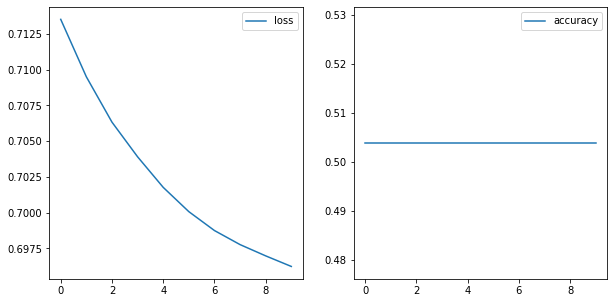

In [21]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy');

We have two plots above both relating to the quality of our model.  The left-hand plot is our loss. It uses the probabilities associated with our predictions to judge how well our prediction fits reality. We want it to decrease as far as possible.

The accuracy judges how well the predictions are after applying the threshold at the output layer.  We want accuracy to increase.

If we look at our loss, it is still decreasing. That is a signal that our model is **still learning**. If our model is still learning, we can allow it to get better by turning a few dials.

Let's:
- increase the number of epochs;
- change sigmoid activation in the hidden layers to ReLU; and
- decrease the batch size.

In [22]:
X_pure_train.shape[0]

1149

In [23]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Assign the variable history to store the results,
# and set verbose=1 so we can see the output.
results = model.fit(X_pure_train, y_pure_train, epochs=100, batch_size=None, verbose=1)

Epoch 1/100
36/36 [==============================] - 1s 3ms/step - loss: 0.6784 - accuracy: 0.5335
Epoch 2/100
36/36 [==============================] - 0s 2ms/step - loss: 0.6632 - accuracy: 0.6023
Epoch 3/100
36/36 [==============================] - 0s 3ms/step - loss: 0.6505 - accuracy: 0.6493
Epoch 4/100
36/36 [==============================] - 0s 2ms/step - loss: 0.6379 - accuracy: 0.6858
Epoch 5/100
36/36 [==============================] - 0s 2ms/step - loss: 0.6246 - accuracy: 0.7076
Epoch 6/100
36/36 [==============================] - 0s 2ms/step - loss: 0.6109 - accuracy: 0.7372
Epoch 7/100
36/36 [==============================] - 0s 2ms/step - loss: 0.5967 - accuracy: 0.7572
Epoch 8/100
36/36 [==============================] - 0s 2ms/step - loss: 0.5820 - accuracy: 0.7746
Epoch 9/100
36/36 [==============================] - 0s 2ms/step - loss: 0.5667 - accuracy: 0.7911
Epoch 10/100
36/36 [==============================] - 0s 2ms/step - loss: 0.5507 - accuracy: 0.8042
Epoch 11/

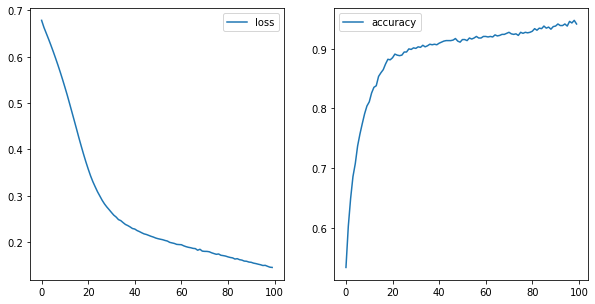

In [24]:
sigmoid_loss = results.history['loss']
sigmoid_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=sigmoid_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=sigmoid_accuracy, ax=ax2, label='accuracy');

If we increase the learning rate to a very high number, we see that our model overshoots the minimum, and starts bouncing all around.

Epoch 1/30


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


115/115 [==============================] - 1s 2ms/step - loss: 1.3741 - accuracy: 0.5248
Epoch 2/30
115/115 [==============================] - 0s 2ms/step - loss: 1.1246 - accuracy: 0.4787
Epoch 3/30
115/115 [==============================] - 0s 2ms/step - loss: 0.9364 - accuracy: 0.5083
Epoch 4/30
115/115 [==============================] - 0s 2ms/step - loss: 1.0306 - accuracy: 0.4900
Epoch 5/30
115/115 [==============================] - 0s 2ms/step - loss: 0.9459 - accuracy: 0.5074
Epoch 6/30
115/115 [==============================] - 0s 2ms/step - loss: 0.9208 - accuracy: 0.5205
Epoch 7/30
115/115 [==============================] - 0s 2ms/step - loss: 0.9843 - accuracy: 0.5048
Epoch 8/30
115/115 [==============================] - 0s 2ms/step - loss: 1.1690 - accuracy: 0.4430
Epoch 9/30
115/115 [==============================] - 0s 2ms/step - loss: 1.0227 - accuracy: 0.4865
Epoch 10/30
115/115 [==============================] - 0s 2ms/step - loss: 1.0239 - accuracy: 0.4891
Epoch 11/3

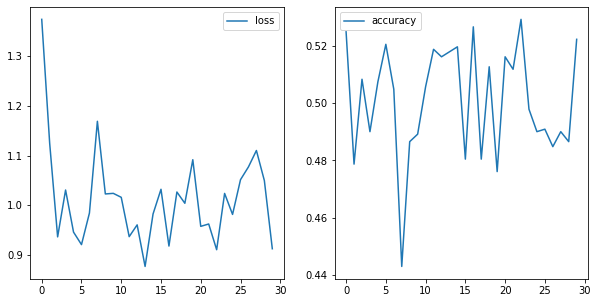

In [25]:
model = Sequential()

sgd = SGD(lr=9)
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=sgd,
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train,
                    epochs=30, batch_size=10, verbose=1)

relu_loss = results.history['loss']
relu_accuracy = results.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=relu_loss, ax=ax1, label='loss')
sns.lineplot(x=results.epoch, y=relu_accuracy, ax=ax2, label='accuracy');

### Exercise

We have been looking only at our training set. Let's add in our validation set to the picture. Check the docstring for the `.fit()` method and add in our validation data.

Epoch 1/30
115/115 [==============================] - 2s 8ms/step - loss: 0.6644 - accuracy: 0.5213 - val_loss: 0.6139 - val_accuracy: 0.6285
Epoch 2/30
115/115 [==============================] - 0s 4ms/step - loss: 0.5590 - accuracy: 0.7337 - val_loss: 0.4811 - val_accuracy: 0.8299
Epoch 3/30
115/115 [==============================] - 0s 3ms/step - loss: 0.4490 - accuracy: 0.8712 - val_loss: 0.4002 - val_accuracy: 0.8993
Epoch 4/30
115/115 [==============================] - 0s 3ms/step - loss: 0.3666 - accuracy: 0.9104 - val_loss: 0.3322 - val_accuracy: 0.9097
Epoch 5/30
115/115 [==============================] - 0s 3ms/step - loss: 0.2979 - accuracy: 0.9199 - val_loss: 0.2763 - val_accuracy: 0.9271
Epoch 6/30
115/115 [==============================] - 0s 3ms/step - loss: 0.2389 - accuracy: 0.9330 - val_loss: 0.2488 - val_accuracy: 0.9236
Epoch 7/30
115/115 [==============================] - 0s 3ms/step - loss: 0.1979 - accuracy: 0.9347 - val_loss: 0.1981 - val_accuracy: 0.9236
Epoch 

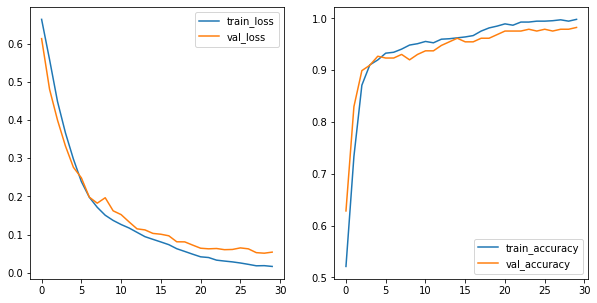

In [26]:
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, validation_data=(X_val, y_val),
                    epochs=30, batch_size=10, verbose=1)

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

<details>
    <summary>One answer here</summary>
<code>model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
results = model.fit(X_pure_train, y_pure_train,
                   validation_data=(X_val, y_val),
                   epochs=30, batch_size=10)
train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')
sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');</code>
</details>

In [27]:
results.history['val_accuracy'][-1]

0.9826388955116272

## Connecting with `sklearn`

The `keras.wrappers` submodule means that we can turn `keras` models into estimators that `sklearn` tools will recognize.

In [28]:
# This will throw an error.

cross_val_score(model, X_pure_train, y_pure_train, scoring = 'accuracy')

TypeError: ignored

In [29]:
def build_model():
    model = Sequential()
    model.add(Dense(12, activation='relu', input_dim=64))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [30]:
keras_model = scikit_learn.KerasClassifier(build_model,
                                           epochs=50,
                                           batch_size=32,
                                           verbose=2)

<ipython-input-30-9939e0b5e565>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_model = scikit_learn.KerasClassifier(build_model,


In [31]:
type(keras_model)

keras.wrappers.scikit_learn.KerasClassifier

In [32]:
cross_val_score(keras_model, X_pure_train, y_pure_train)

Epoch 1/50
29/29 - 1s - loss: 0.6620 - accuracy: 0.6583 - 621ms/epoch - 21ms/step
Epoch 2/50
29/29 - 0s - loss: 0.6054 - accuracy: 0.7737 - 67ms/epoch - 2ms/step
Epoch 3/50
29/29 - 0s - loss: 0.5185 - accuracy: 0.8259 - 67ms/epoch - 2ms/step
Epoch 4/50
29/29 - 0s - loss: 0.4223 - accuracy: 0.8564 - 64ms/epoch - 2ms/step
Epoch 5/50
29/29 - 0s - loss: 0.3443 - accuracy: 0.8836 - 63ms/epoch - 2ms/step
Epoch 6/50
29/29 - 0s - loss: 0.2956 - accuracy: 0.8923 - 63ms/epoch - 2ms/step
Epoch 7/50
29/29 - 0s - loss: 0.2579 - accuracy: 0.9119 - 57ms/epoch - 2ms/step
Epoch 8/50
29/29 - 0s - loss: 0.2350 - accuracy: 0.9173 - 68ms/epoch - 2ms/step
Epoch 9/50
29/29 - 0s - loss: 0.2141 - accuracy: 0.9238 - 62ms/epoch - 2ms/step
Epoch 10/50
29/29 - 0s - loss: 0.1987 - accuracy: 0.9293 - 62ms/epoch - 2ms/step
Epoch 11/50
29/29 - 0s - loss: 0.1852 - accuracy: 0.9347 - 56ms/epoch - 2ms/step
Epoch 12/50
29/29 - 0s - loss: 0.1743 - accuracy: 0.9369 - 68ms/epoch - 2ms/step
Epoch 13/50
29/29 - 0s - loss: 0.16

array([0.97391301, 0.94347829, 0.96086955, 0.95652175, 0.96943229])

## Level Up: Regularization

Does regularization make sense in the context of neural networks? <br/>

Yes! We still have all of the salient ingredients: a loss function, overfitting vs. underfitting, and coefficients (weights) that could get too large.

But there are now a few different flavors besides L1 and L2 regularization. (Note that L1 regularization is not common in the context of  neural networks.)

We'll add a few more layers to give regularization a better chance of making a difference!

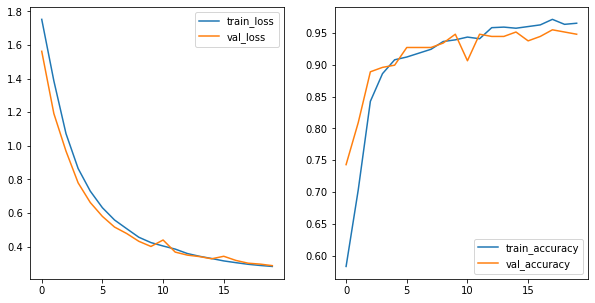

In [33]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))

# We can add L2 (or L1) regularization right into
# the layer with the kernel_regularizer parameter.

model.add(Dense(20, activation='relu',
                kernel_regularizer=l2(l2=0.05)))

# Note that there is also a bias_regularizer,
# but this tends to have less effect.

model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

Adding L2 to multiple layers:

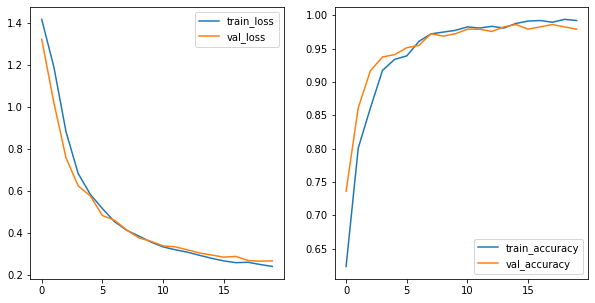

In [34]:
model = Sequential()
model.add(Dense(30, activation='relu',
                input_dim=64))
model.add(Dense(20, activation='relu',
                kernel_regularizer=l2(l2=0.01)))

model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(12, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(8, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(4, activation='relu',
                kernel_regularizer=l2(l2=0.01)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

### Dropout

We can also specify a dropout layer in keras, which randomly shuts off different nodes during training. This can help to prevent overfitting.

![drop_out](https://raw.githubusercontent.com/flatiron-school/DS-Instructor-Content/main/Deep-Learning/Network-Regularization-Evaluation/images/drop_out.png?token=GHSAT0AAAAAAB6I4Q5QROZWFEQMDAIWKTKIY7GMBZQ)

### Exercise

To add dropout to a `keras` network, simply add it as though it were a layer. It will apply to the immediately preceding layer.

Add Dropout to one or more layers below.

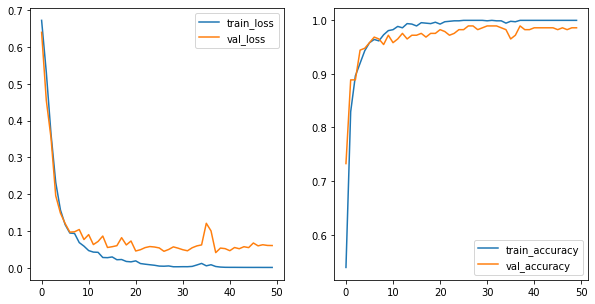

In [35]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=50,
                    batch_size= 32, verbose=0,
                    validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

<details>
    <summary>One answer here</summary>
<code>model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train, epochs=50,
                    batch_size= 32, verbose=0,
                    validation_data=(X_val, y_val))

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');</code>
</details>

In [36]:
results.history['val_accuracy'][-1]

0.9861111044883728

### Early Stopping

We can also tell our neural network to stop once it stops realizing any gain.

Here we tell it to stop once the a very small positive change in the validation loss occurs:

Epoch 2: early stopping


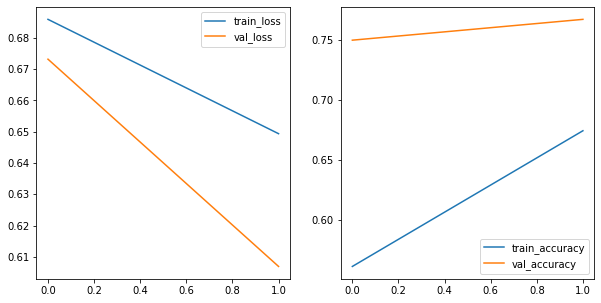

In [37]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                           verbose=1,
                           mode='min')

# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=20, batch_size=32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

### Exercise

That probably stopped too early. We can specify the number of epochs in which it doesn't see decrease in the loss with the `patience` parameter. Modify the code below to include an Early Stop with a patience of 5 epochs.

Epoch 24: early stopping


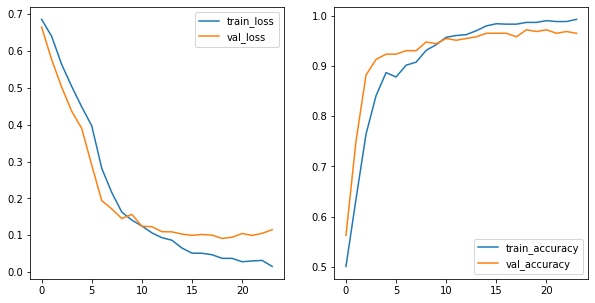

In [38]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                           verbose=1, patience=5,
                           mode='min')

# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=50, batch_size= 32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

<details>
    <summary>One answer here</summary>
<code>model = Sequential()
model.add(Dense(30, activation='relu', input_dim=64))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the EarlyStopping object



# Place this in a list as the value of the `callbacks` parameter
# in the `.fit()` method.
results = model.fit(X_pure_train, y_pure_train,
                    epochs=50, batch_size= 32,
                    verbose=0, validation_data=(X_val, y_val),
                    callbacks=[early_stop])

train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');</code>
</details>

In [39]:
results.history['val_accuracy'][-1]

0.9652777910232544

## Multiclass Classification and Softmax

Now let's return to the problem of predicting digits 0 through 9.

In [40]:
digits = load_digits()
X = digits.data
y = digits.target

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)
X_pure_train, X_val, y_pure_train, y_val =\
    train_test_split(X_train, y_train,
                     random_state=42, test_size=0.2)
X_pure_train, X_val, X_test = X_pure_train/16, X_val/16, X_test/16

For a multiclass output, our neural net expects our target to be in a certain form.

In [42]:
ohe = OneHotEncoder(sparse=False)
y_pure_train = ohe.fit_transform(y_pure_train.reshape(-1,1))
y_val = ohe.transform(y_val.reshape(-1,1))
y_test = ohe.transform(y_test.reshape(-1,1))

In [43]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [44]:
# Model from above, but now with ten output neurons:

model = Sequential()
model.add(Dense(12, activation='relu', input_dim=64))
model.add(Dense(8, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

results = model.fit(X_pure_train, y_pure_train,
                   epochs=50, batch_size=10,
                   validation_data=(X_val, y_val))

Epoch 1/50
115/115 [==============================] - 1s 5ms/step - loss: 2.2440 - accuracy: 0.1288 - val_loss: 2.1230 - val_accuracy: 0.2049
Epoch 2/50
115/115 [==============================] - 0s 3ms/step - loss: 1.9521 - accuracy: 0.2715 - val_loss: 1.7499 - val_accuracy: 0.3785
Epoch 3/50
115/115 [==============================] - 0s 3ms/step - loss: 1.5177 - accuracy: 0.5065 - val_loss: 1.3403 - val_accuracy: 0.6007
Epoch 4/50
115/115 [==============================] - 0s 3ms/step - loss: 1.1294 - accuracy: 0.7032 - val_loss: 1.0113 - val_accuracy: 0.7535
Epoch 5/50
115/115 [==============================] - 0s 3ms/step - loss: 0.8632 - accuracy: 0.7850 - val_loss: 0.8014 - val_accuracy: 0.7847
Epoch 6/50
115/115 [==============================] - 0s 3ms/step - loss: 0.6846 - accuracy: 0.8172 - val_loss: 0.6525 - val_accuracy: 0.8368
Epoch 7/50
115/115 [==============================] - 0s 3ms/step - loss: 0.5605 - accuracy: 0.8564 - val_loss: 0.5612 - val_accuracy: 0.8368
Epoch 

$$\large \text{Softmax}(x_{i}) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}$$

The sofmax function outputs a number between 0 and 1 for each of our classes.  All of the probabilities of the classes sum up to 1.

The number of nodes in our output layer equals the number of categories in our dataset.

We also need a new loss function: **categorical crossentropy**, which calculates a separate loss for each label and then sums the results.

In [45]:
history = results.history
training_loss = history['loss']
val_loss = history['val_loss']
training_accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

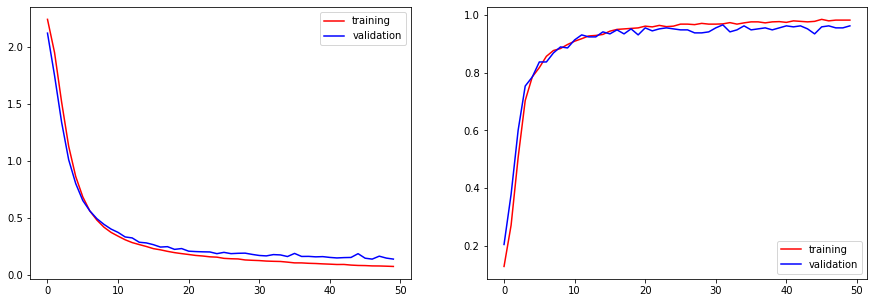

In [46]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))


sns.lineplot(x=list(range(len(training_loss))),
             y=training_loss, color='r', label='training', ax=ax1)
sns.lineplot(x=list(range(len(val_loss))),
             y=val_loss, color='b', label='validation', ax=ax1)
sns.lineplot(x=list(range(len(training_loss))),
             y=training_accuracy, color='r', label='training',ax=ax2)
sns.lineplot(x=list(range(len(val_loss))),
             y=val_accuracy, color='b', label='validation',ax=ax2)
ax1.legend();

In [47]:
y_hat_test = np.argmax(model.predict(X_test), axis=-1)

12/12 [==============================] - 0s 3ms/step


In [48]:
y_test_restore = ohe.inverse_transform(y_test)
confusion_matrix(y_test_restore, y_hat_test)

array([[30,  0,  0,  0,  1,  1,  1,  0,  0,  0],
       [ 0, 28,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1, 28,  2,  0,  0,  0,  0,  2,  0],
       [ 0,  0,  1, 32,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 46,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0, 44,  0,  0,  0,  2],
       [ 0,  0,  0,  0,  1,  0, 34,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 33,  0,  1],
       [ 0,  1,  1,  0,  0,  1,  0,  0, 26,  1],
       [ 0,  1,  0,  1,  0,  0,  0,  1,  0, 37]])

Wow, look at that performance!  

That is great, but remember, we were dealing with simple black and white images.  With color, our basic neural net will have less success.

We will explore more advanced tools in the coming days.
